# Imports & loading

In [15]:
from support import load_dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from tqdm.notebook import tqdm 

import pandas as pd

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
)
import plotly

In [16]:
import torch, gc, os

def get_device():
    if torch.backends.mps.is_available():         # Apple GPU
        return torch.device("mps")
    elif torch.cuda.is_available():               # NVIDIA eGPU etc.
        return torch.device("cuda")
    else:                                         # fallback
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.set_float32_matmul_precision("high")        # speeds M-series matmul
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"   # CPU fallback for missing ops


Using device: mps


#### Print Python and PyTorch version

In [17]:
print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python version: 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
PyTorch version: 2.7.0
CUDA available: False


In [18]:
# pin_memory_flag   = device.type == 'cuda'
# num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
# print(f"Pin memory: {pin_memory_flag}, Num workers: {num_workers_flag}")

In [19]:
# import torch, time
# x = torch.randn(8192, 8192, device='mps')
# t0 = time.perf_counter()
# y = x @ x.T
# torch.mps.synchronize()     # wait for GPU
# print("took %.2f s" % (time.perf_counter() - t0))


In [20]:
data = load_dataset()
train_dataset = data[0]
test_dataset = data[1]

In [21]:
img, label = train_dataset[0]

print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Train_dataset: {train_dataset}")

Image shape: torch.Size([3, 60, 30])
Label: 0
Train_dataset: Dataset ImageFolder
    Number of datapoints: 136
    Root location: WF-data/train
    StandardTransform
Transform: Compose(
               Resize(size=[105, 78], interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=[60, 30])
               ToTensor()
           )


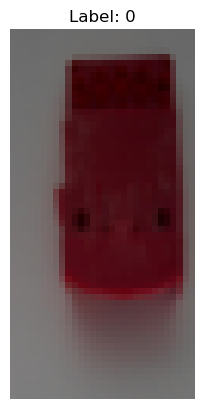

In [22]:
img_tensor, label = train_dataset[0]
transform_to_pil = T.ToPILImage()
img_pil = transform_to_pil(img_tensor)

plt.imshow(img_pil)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# CNN

## Base Model

In [23]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x H/2 x W/2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: 32 x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically to connect conv layers to fc layers
        with torch.no_grad(): # We don't need gradients for this calculation
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            # Output 1 logit for binary classification (labels 0 or 1)
            # This will be used with BCEWithLogitsLoss
            nn.Linear(128, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters
learning_rate = 0.007
batch_size = 16 # Adjust this based on memory
num_epochs = 40  # Adjust as needed for convergence
num_classes = 2  # Binary classification (labels 0 and 1)

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes).to(device)
# model = torch.compile(model)

# Binary Cross Entropy with Logits Loss, suitable for binary classification with one output neuron
criterion = nn.BCEWithLogitsLoss() # Different choiches possible
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # Reshape labels to [batch_size, 1] and convert to float for BCEWithLogitsLoss
        labels = labels.to(device).float().unsqueeze(1) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if (i + 1) % max(1, len(train_loader) // 10) == 0: # Print progress, e.g. 10 times per epoch
            # print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    avg_epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1) #
            
            # predictions on the test set
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect() 

    
# Save the model
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print("Finished Training")
print(f"Model saved to {model_path}")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/40 [00:00<?, ?epoch/s]

Epoch [1/40] completed. Average Training Loss: 0.7157
Accuracy on test set after epoch 1: 50.00%
Epoch [2/40] completed. Average Training Loss: 0.6952
Accuracy on test set after epoch 2: 50.00%
Epoch [3/40] completed. Average Training Loss: 0.6930
Accuracy on test set after epoch 3: 50.00%
Epoch [4/40] completed. Average Training Loss: 0.6902
Accuracy on test set after epoch 4: 50.00%
Epoch [5/40] completed. Average Training Loss: 0.6727
Accuracy on test set after epoch 5: 50.00%
Epoch [6/40] completed. Average Training Loss: 0.6604
Accuracy on test set after epoch 6: 58.82%
Epoch [7/40] completed. Average Training Loss: 0.5511
Accuracy on test set after epoch 7: 64.71%
Epoch [8/40] completed. Average Training Loss: 0.4779
Accuracy on test set after epoch 8: 73.53%
Epoch [9/40] completed. Average Training Loss: 0.4136
Accuracy on test set after epoch 9: 76.47%
Epoch [10/40] completed. Average Training Loss: 0.3754
Accuracy on test set after epoch 10: 76.47%
Epoch [11/40] completed. Ave

In [ ]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters
learning_rate = 0.007
batch_size = 16 # Adjust this based on memory
num_epochs = 40  # Adjust as needed for convergence
num_classes = 2  # Binary classification (labels 0 and 1)

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes).to(device)
# model = torch.compile(model)

# Binary Cross Entropy with Logits Loss, suitable for binary classification with one output neuron
criterion = nn.BCEWithLogitsLoss() # Different choiches possible
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # Reshape labels to [batch_size, 1] and convert to float for BCEWithLogitsLoss
        labels = labels.to(device).float().unsqueeze(1) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if (i + 1) % max(1, len(train_loader) // 10) == 0: # Print progress, e.g. 10 times per epoch
            # print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    avg_epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1) #
            
            # predictions on the test set
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect() 

    
# Save the model
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print("Finished Training")
print(f"Model saved to {model_path}")

## Increased complexity

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes,
                 conv1_out_channels=16, conv2_out_channels=32, fc_neurons=128):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, conv1_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: conv1_out_channels x H/2 x W/2
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: conv2_out_channels x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [26]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters (Base Model)
learning_rate = 0.001
batch_size = 16 
num_epochs = 40 
num_classes = 2 

# Default architectural parameters for the base model
conv1_out_channels_base = 16
conv2_out_channels_base = 32
fc_neurons_base = 128

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Use the (potentially modified) SimpleCNN class
model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes,
                    conv1_out_channels=conv1_out_channels_base, 
                    conv2_out_channels=conv2_out_channels_base, 
                    fc_neurons=fc_neurons_base).to(device)
# model = torch.compile(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store metrics for plotting
epoch_train_losses = []
epoch_test_accuracies = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1) 

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch
    
    avg_epoch_loss = running_loss / len(train_loader.dataset)  # Average loss over the entire training set
    epoch_train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    epoch_test_accuracies.append(accuracy)
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect()                        # reclaim Python-held objects

print("Finished Training Base Model")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/40 [00:00<?, ?epoch/s]

Epoch [1/40] completed. Average Training Loss: 0.6985
Accuracy on test set after epoch 1: 50.00%
Epoch [2/40] completed. Average Training Loss: 0.6923
Accuracy on test set after epoch 2: 50.00%
Epoch [3/40] completed. Average Training Loss: 0.6920
Accuracy on test set after epoch 3: 58.82%
Epoch [4/40] completed. Average Training Loss: 0.6887
Accuracy on test set after epoch 4: 76.47%
Epoch [5/40] completed. Average Training Loss: 0.6832
Accuracy on test set after epoch 5: 50.00%
Epoch [6/40] completed. Average Training Loss: 0.6816
Accuracy on test set after epoch 6: 61.76%
Epoch [7/40] completed. Average Training Loss: 0.6610
Accuracy on test set after epoch 7: 61.76%
Epoch [8/40] completed. Average Training Loss: 0.6230
Accuracy on test set after epoch 8: 61.76%
Epoch [9/40] completed. Average Training Loss: 0.5725
Accuracy on test set after epoch 9: 61.76%
Epoch [10/40] completed. Average Training Loss: 0.5582
Accuracy on test set after epoch 10: 67.65%
Epoch [11/40] completed. Ave

### Plots

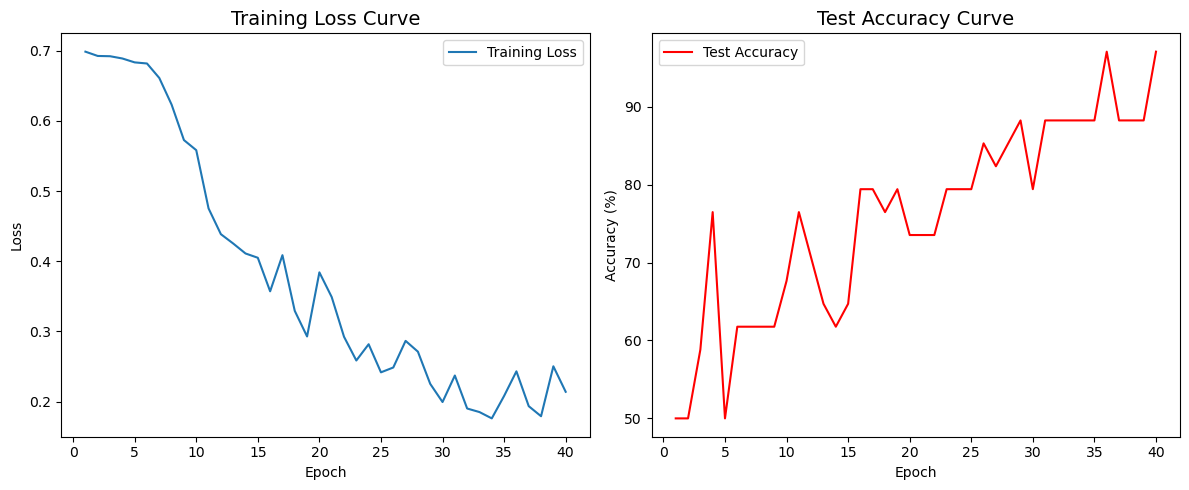

In [27]:
# Plotting learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter tuning

### Random Search

In [28]:
# Device configuration
device = get_device()
print(f"Using device for hyperparameter tuning: {device}")

# Get image dimensions (C, H, W should be available from the previous cell or re-derived)
if 'C' not in locals() or 'H' not in locals() or 'W' not in locals():
    sample_img, _ = train_dataset[0]
    C, H, W = sample_img.shape
    print(f"Re-detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameter search space
param_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'batch_size': [8, 16, 32],
    'conv1_out_channels': [8, 16, 32],
    'conv2_out_channels': [16, 32, 64],
    'fc_neurons': [64, 128, 256],
}

num_classes_hp = 2
num_epochs_search = 40 # Fewer epochs for faster search, adjust as needed
num_trials = 10 # Number of random hyperparameter sets to try

best_hyperparams = None
best_val_accuracy = -1.0
best_model_state = None

# Store history for the best model's learning curves
best_model_train_losses = []
best_model_val_accuracies = []

perfect_found = False

for trial in tqdm(range(num_trials), desc="Hyperparameter Search Trials", unit="trial", leave=True):
    if perfect_found:
        print("Perfect hyperparameters found, stopping further trials.")
        break

    # Randomly sample hyperparameters
    current_params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Testing params: {current_params}")

    # DataLoaders with current batch size
    pin_memory_flag   = device.type == 'cuda'
    num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

    try:
        current_train_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        current_val_loader = DataLoader(test_dataset, batch_size=current_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    except Exception as e:
        print(f"Error creating DataLoader, possibly due to batch size: {e}. Skipping trial.")
        continue


    # Model
    model_hp = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                            conv1_out_channels=current_params['conv1_out_channels'],
                            conv2_out_channels=current_params['conv2_out_channels'],
                            fc_neurons=current_params['fc_neurons']).to(device)
    # model_hp = torch.compile(model_hp)

    criterion_hp = nn.BCEWithLogitsLoss()
    
    optimizer_hp = optim.Adam(model_hp.parameters(), lr=current_params['learning_rate'])

    trial_train_losses = []
    trial_val_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs_search), desc=f"Trial {trial+1} Training", leave=True):
        model_hp.train()
        epoch_running_loss = 0.0
        for images, labels in current_train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_hp.zero_grad()
            outputs = model_hp(images)
            loss = criterion_hp(outputs, labels)
            loss.backward()
            optimizer_hp.step()
            epoch_running_loss += loss.item() * images.size(0)
        
        avg_epoch_train_loss = epoch_running_loss / len(current_train_loader.dataset)
        trial_train_losses.append(avg_epoch_train_loss)

        # Validation
        model_hp.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in current_val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model_hp(images)
                val_running_loss += criterion_hp(outputs, labels).item() * images.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        current_epoch_val_accuracy = 100 * val_correct / val_total
        trial_val_accuracies.append(current_epoch_val_accuracy)
        avg_epoch_val_loss = val_running_loss / len(current_val_loader.dataset)

        
        # print(f"Trial {trial+1} Epoch {epoch+1}: Train Loss: {avg_epoch_train_loss:.4f}, Val Accuracy: {current_epoch_val_accuracy:.2f}%")
        if current_epoch_val_accuracy == 100.0:
            # ADDED: if we see 100% this epoch, set perfect_found=True and record epoch
            perfect_found = True
            first_perfect_epoch = epoch + 1
            print(f"→ 100% accuracy reached at epoch {epoch+1}")

        else:
            # ADDED: if accuracy dropped below 100% after a prior perfect, reset perfect_found
            if perfect_found:
                perfect_found = False
                first_perfect_epoch = None
                print(f"→ accuracy dropped below 100% at epoch {epoch+1}, resetting perfect flag")

        # ADDED: Only stop early on val_loss if we are still at 100% this epoch
        if perfect_found and avg_epoch_val_loss < 0.02:
            print(f"→ val_loss = {avg_epoch_val_loss:.4f} < 0.02 and accuracy is still 100% at epoch {epoch+1}, stopping early")
            break

        # if current_epoch_val_accuracy == 100.0:
        #     perfect_found = True
        #     break            

        if device.type == "mps":            # Apple-GPU path
            torch.mps.empty_cache()
        elif device.type == "cuda":         # NVIDIA-GPU path
            torch.cuda.empty_cache()
        gc.collect()                        # reclaim Python-held objects
        
    # Check if this trial is the best so far (based on final epoch's validation accuracy)
    if trial_val_accuracies and current_epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_epoch_val_accuracy
        best_hyperparams = current_params
        best_model_state = model_hp.state_dict() # Save the model state
        best_model_train_losses = trial_train_losses # Save learning curves for this best model
        best_model_val_accuracies = trial_val_accuracies
        print(f"New best model found! Training loss: {trial_train_losses[-1]:.4f}, Val Accuracy: {best_val_accuracy:.2f}%, Params: {best_hyperparams}")
    
    if perfect_found:
        break

print("\nFinished Hyperparameter Search.")

# Save the best model found during hyperparameter search
best_randomsearch_model_path = "best_randomsearch_cnn_model.pth"
torch.save(best_model_state, best_randomsearch_model_path)
print(f"Best randomsearch model saved to {best_randomsearch_model_path}")
   

Using device for hyperparameter tuning: mps


Hyperparameter Search Trials:   0%|          | 0/10 [00:00<?, ?trial/s]

Testing params: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 256}


Trial 1 Training:   0%|          | 0/40 [00:00<?, ?it/s]

New best model found! Training loss: 0.6933, Val Accuracy: 50.00%, Params: {'learning_rate': 0.005, 'batch_size': 8, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 256}
Testing params: {'learning_rate': 0.001, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 128}


Trial 2 Training:   0%|          | 0/40 [00:00<?, ?it/s]

New best model found! Training loss: 0.1932, Val Accuracy: 85.29%, Params: {'learning_rate': 0.001, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 64, 'fc_neurons': 128}
Testing params: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 128}


Trial 3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

→ 100% accuracy reached at epoch 8
→ 100% accuracy reached at epoch 9
→ 100% accuracy reached at epoch 10
→ 100% accuracy reached at epoch 11
→ accuracy dropped below 100% at epoch 12, resetting perfect flag
→ 100% accuracy reached at epoch 13
→ accuracy dropped below 100% at epoch 14, resetting perfect flag
→ 100% accuracy reached at epoch 19
→ 100% accuracy reached at epoch 20
→ accuracy dropped below 100% at epoch 21, resetting perfect flag
→ 100% accuracy reached at epoch 22
→ accuracy dropped below 100% at epoch 23, resetting perfect flag
→ 100% accuracy reached at epoch 25
→ 100% accuracy reached at epoch 26
→ 100% accuracy reached at epoch 27
→ 100% accuracy reached at epoch 28
→ 100% accuracy reached at epoch 29
→ accuracy dropped below 100% at epoch 30, resetting perfect flag
→ 100% accuracy reached at epoch 32
→ 100% accuracy reached at epoch 33
→ 100% accuracy reached at epoch 34
→ 100% accuracy reached at epoch 35
→ val_loss = 0.0154 < 0.02 and accuracy is still 100% at epo

#### Plots

Best Validation Accuracy: 100.00%
Best Hyperparameters: {'learning_rate': 0.005, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 128}
Number of epochs needed: 35


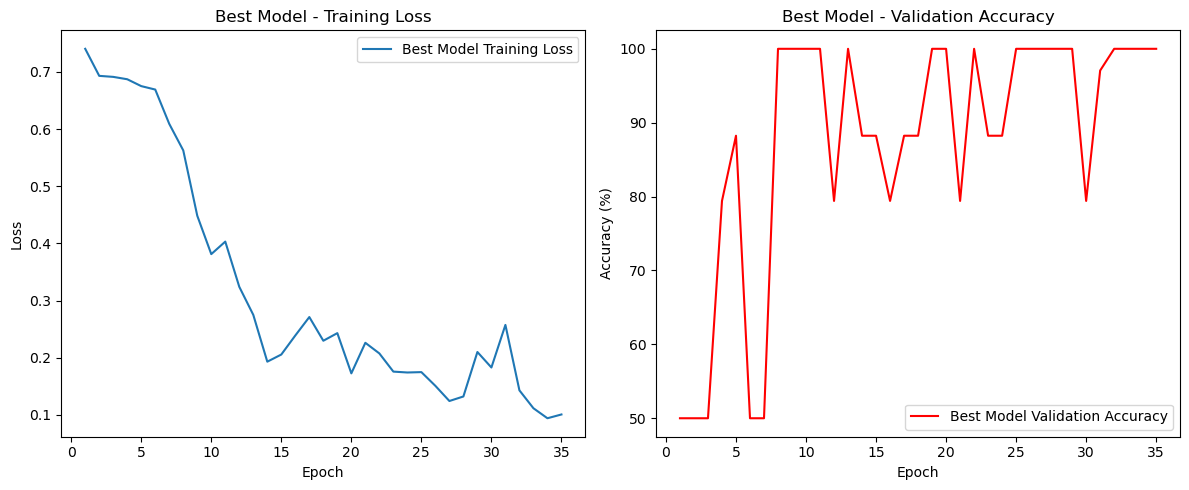

In [29]:
epochs = list(range(1, len(best_model_train_losses) + 1))

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Number of epochs needed: {len(epochs)}")


# Plotting learning curves for the best model from hyperparameter search
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, best_model_train_losses, label='Best Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Model - Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, best_model_val_accuracies, label='Best Model Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Best Model - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model state for further use if needed:
# model_best = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp, **best_hyperparams_arch).to(device)
# model_best.load_state_dict(best_model_state)
# where best_hyperparams_arch = {k: v for k,v in best_hyperparams.items() if k in ['conv1_out_channels', 'conv2_out_channels', 'fc_neurons']}

### Method 2 - Optuna

In [30]:
# %pip install optuna
# %pip install --upgrade pip

In [41]:
# Device configuration
device = get_device()
print(f"Using device for Optuna hyperparameter tuning: {device}")

# Get image dimensions
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Image shape: Channels={C}, Height={H}, Width={W}")

num_classes_hp = 2
num_epochs_search = 40 # Fewer epochs for faster search, adjust as needed for Optuna trials
num_trials_optuna = 10 # Define number of trials

def stop_when_perfect(study, trial):
    if trial.value is not None and trial.value >= 100.0:
        study.stop()

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    conv1_out = trial.suggest_categorical("conv1_out_channels", [8, 16, 32, 64])
    conv2_out = trial.suggest_categorical("conv2_out_channels", [16, 32, 64, 128])
    fc_neurons_val = trial.suggest_categorical("fc_neurons", [64, 128, 256])

    # DataLoaders
    pin_memory_flag   = device.type == 'cuda'
    num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

    try:
        current_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        current_val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    except Exception as e:
        print(f"Error creating DataLoader for trial {trial.number}: {e}. Pruning trial.")
        raise optuna.exceptions.TrialPruned()


    # Model (Ensure SimpleCNN class is defined and accessible)
    model_opt = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                          conv1_out_channels=conv1_out,
                          conv2_out_channels=conv2_out,
                          fc_neurons=fc_neurons_val).to(device)

    criterion_opt = nn.BCEWithLogitsLoss()
    optimizer_opt = optim.Adam(model_opt.parameters(), lr=lr)

    trial_train_losses = []
    trial_val_accuracies = []

    patience = 10
    best_val_acc = 0.0
    epochs_no_improve = 0

    # Training loop
    for epoch in tqdm(range(num_epochs_search), desc=f"Trial {trial.number} [Training]", leave=True):
        model_opt.train()
        epoch_running_loss = 0.0
        for images, labels in current_train_loader: # train_pbar_opt:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer_opt.zero_grad(set_to_none=True)
            loss = criterion_opt(model_opt(images), labels)
            loss.backward()
            optimizer_opt.step()

            epoch_running_loss += loss.item() * images.size(0)

        trial_train_losses.append(epoch_running_loss / len(train_loader.dataset))

        # Validation
        model_opt.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in current_val_loader: # val_pbar_opt:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model_opt(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        current_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0
        trial_val_accuracies.append(current_epoch_val_accuracy)
        
        if current_epoch_val_accuracy > best_val_acc:
            best_val_acc = current_epoch_val_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} for trial {trial.number}. No improvement in validation accuracy for {patience} epochs.")
            break

        if current_epoch_val_accuracy == 100.0:
            print(f"Perfect validation accuracy reached at epoch {epoch+1} for trial {trial.number}. Stopping early.")
            break

        # Optuna pruning (optional, but good for long searches)
        trial.report(current_epoch_val_accuracy, epoch)
        if trial.should_prune():
            # Store partial curves if pruned
            trial.set_user_attr("train_losses", trial_train_losses)
            trial.set_user_attr("val_accuracies", trial_val_accuracies)
            raise optuna.exceptions.TrialPruned()

    # Store full learning curves in user attributes for the trial
    trial.set_user_attr("train_losses", trial_train_losses)
    trial.set_user_attr("val_accuracies", trial_val_accuracies)

    del model_opt, optimizer_opt, criterion_opt, current_train_loader, current_val_loader  
    if device.type == "mps":                                   
        torch.mps.empty_cache()
    elif device.type == "cuda":                                
        torch.cuda.empty_cache()
    gc.collect()   

    return best_val_acc
    # return trial_val_accuracies[-1] # Return final validation accuracy

# Create a study object and optimize
# You can add a pruner, e.g., optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_min_trials=3, n_warmup_steps=3))
# study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True)
study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True, callbacks=[stop_when_perfect], show_progress_bar=True)


print("\nFinished Optuna Hyperparameter Search.")
best_trial_optuna = study.best_trial
best_hyperparams_optuna = best_trial_optuna.params
best_val_accuracy_optuna = best_trial_optuna.value


# Retrieve learning curves for the best trial
best_model_train_losses_optuna = best_trial_optuna.user_attrs.get("train_losses", [])
best_model_val_accuracies_optuna = best_trial_optuna.user_attrs.get("val_accuracies", [])

[I 2025-06-05 12:21:45,740] A new study created in memory with name: no-name-603d0732-0e70-43ab-9a7d-538bc0273ace


Using device for Optuna hyperparameter tuning: mps
Image shape: Channels=3, Height=60, Width=30


  0%|          | 0/10 [00:00<?, ?it/s]

Trial 0 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 15 for trial 0. No improvement in validation accuracy for 10 epochs.
[I 2025-06-05 12:25:14,109] Trial 0 finished with value: 76.47058823529412 and parameters: {'learning_rate': 0.00021261604824590467, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc_neurons': 64}. Best is trial 0 with value: 76.47058823529412.


Trial 1 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 37 for trial 1. No improvement in validation accuracy for 10 epochs.
[I 2025-06-05 12:33:44,748] Trial 1 finished with value: 88.23529411764706 and parameters: {'learning_rate': 0.00031343393728105757, 'batch_size': 8, 'conv1_out_channels': 64, 'conv2_out_channels': 64, 'fc_neurons': 128}. Best is trial 1 with value: 88.23529411764706.


Trial 2 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 31 for trial 2. No improvement in validation accuracy for 10 epochs.
[I 2025-06-05 13:39:13,865] Trial 2 finished with value: 76.47058823529412 and parameters: {'learning_rate': 0.00021782450315626522, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 16, 'fc_neurons': 64}. Best is trial 1 with value: 88.23529411764706.


Trial 3 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 13 for trial 3. No improvement in validation accuracy for 10 epochs.
[I 2025-06-05 13:44:53,408] Trial 3 finished with value: 70.58823529411765 and parameters: {'learning_rate': 0.00017065987825603418, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 16, 'fc_neurons': 64}. Best is trial 1 with value: 88.23529411764706.


Trial 4 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Perfect validation accuracy reached at epoch 21 for trial 4. Stopping early.
[I 2025-06-05 13:49:47,637] Trial 4 finished with value: 100.0 and parameters: {'learning_rate': 0.0022635386141082246, 'batch_size': 16, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 256}. Best is trial 4 with value: 100.0.

Finished Optuna Hyperparameter Search.


In [42]:
fig1 = plot_optimization_history(study)
fig1.show()  # in Jupyter this will render an interactive Plotly chart


In [43]:
fig2 = plot_param_importances(study)
fig2.show()


In [44]:
fig3 = plot_parallel_coordinate(study)
fig3.show()


In [45]:
fig4 = plot_slice(study, params=["learning_rate", "batch_size", "conv1_out_channels"])
fig4.show()

In [46]:
fig5 = plot_contour(study, params=["learning_rate", "batch_size"])
fig5.show()

In [47]:
train_losses = best_trial_optuna.user_attrs.get("train_losses", [])
val_accs     = best_trial_optuna.user_attrs.get("val_accuracies", [])

df = pd.DataFrame({
    "epoch": list(range(1, len(train_losses) + 1)),
    "train_loss": train_losses,
    "val_accuracy": val_accs,
})
df.to_csv("best_trial_curves.csv", index=False)
# df

## Retrain best optuna model

In [ ]:
# After Optuna optimization, retrain the best model with the best hyperparameters and save it

# Extract best hyperparameters from the Optuna study
best_params = study.best_trial.params

# Dataloaders with the best batch size
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

train_loader_opt = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
val_loader_opt = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Re-create and train the model with the best hyperparameters
model_optimal = SimpleCNN(
    input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
    conv1_out_channels=best_params['conv1_out_channels'],
    conv2_out_channels=best_params['conv2_out_channels'],
    fc_neurons=best_params['fc_neurons']
).to(device)

criterion_opt = nn.BCEWithLogitsLoss()
optimizer_opt = optim.Adam(model_optimal.parameters(), lr=best_params['learning_rate'])
num_epochs_opt = num_epochs_search  # Or set to a higher value for final training

for epoch in tqdm(range(num_epochs_opt), desc=f"Epoch {trial+1} Training", leave=True):
# for epoch in range(num_epochs_opt):
    model_optimal.train()
    for images, labels in train_loader_opt:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer_opt.zero_grad()
        outputs = model_optimal(images)
        loss = criterion_opt(outputs, labels)
        loss.backward()
        optimizer_opt.step()

# Save the trained optimal model
best_optuna_model_path = "best_optuna_cnn_model.pth"
torch.save(model_optimal.state_dict(), best_optuna_model_path)
print(f"Optimal model saved to {best_optuna_model_path}")


Epoch 3 Training:   0%|          | 0/40 [00:00<?, ?it/s]

#### Plots

Best Validation Accuracy (from Optuna study): 100%
Best Hyperparameters (from Optuna study): {'learning_rate': 0.0022635386141082246, 'batch_size': 16, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 256}
Number of epochs needed: 40


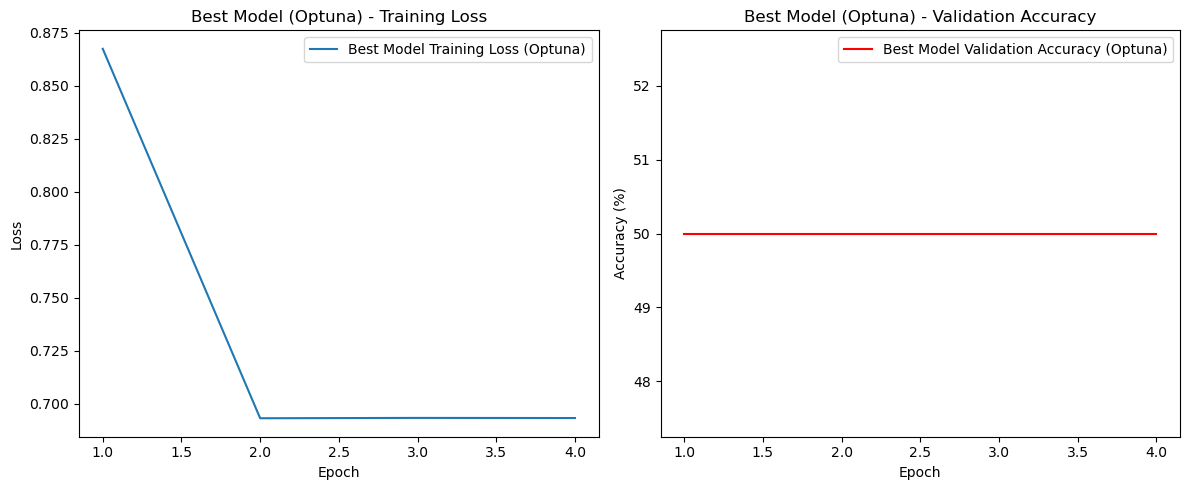

In [ ]:
print(f"Best Validation Accuracy (from Optuna study): {best_val_accuracy_optuna:.0f}%")
print(f"Best Hyperparameters (from Optuna study): {best_hyperparams_optuna}")
print(f"Number of epochs needed: {num_epochs_opt}")

# Plotting learning curves for the best model from Optuna hyperparameter search
if best_model_train_losses_optuna and best_model_val_accuracies_optuna:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_model_train_losses_optuna) + 1), best_model_train_losses_optuna, label='Best Model Training Loss (Optuna)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model (Optuna) - Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_model_val_accuracies_optuna) + 1), best_model_val_accuracies_optuna, label='Best Model Validation Accuracy (Optuna)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Best Model (Optuna) - Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the best Optuna trial is not available.")
    
# You can now load the best model state for further use if needed.
# First, you'd typically retrain a model with best_hyperparams_optuna for a full number of epochs
# and save its state_dict. The state_dict is not directly saved by the Optuna objective function above.
# Example:
# model_best_optuna = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
#                               conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
#                               conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
#                               fc_neurons=best_hyperparams_optuna['fc_neurons']).to(device)
# # Then, you would train this model_best_optuna using the best learning rate, optimizer, and batch size.
# # For now, we are just plotting the curves from the optimization search itself.

In [55]:
# --- 1. Retrieve best hyperparameters from the Optuna study ---
best_hyperparams_optuna = study.best_trial.params

# --- 2. Create dataloaders using the best batch size ---
pin_memory_flag  = (device.type == 'cuda')
num_workers_flag = 2 if device.type == 'cuda' else 0

train_loader_opt = DataLoader(
    train_dataset,
    batch_size=best_hyperparams_optuna['batch_size'],
    shuffle=True,
    num_workers=num_workers_flag,
    pin_memory=pin_memory_flag
)

val_loader_opt = DataLoader(
    test_dataset,
    batch_size=best_hyperparams_optuna['batch_size'],
    shuffle=False,
    num_workers=num_workers_flag,
    pin_memory=pin_memory_flag
)

# --- 3. Re‐create the model with the best hyperparameters ---
model_optimal = SimpleCNN(
    input_channels=C,
    input_height=H,
    input_width=W,
    num_classes=num_classes_hp,
    conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
    conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
    fc_neurons=best_hyperparams_optuna['fc_neurons']
).to(device)

criterion_opt = nn.BCEWithLogitsLoss()
optimizer_opt = optim.Adam(
    model_optimal.parameters(),
    lr=best_hyperparams_optuna['learning_rate']
)

num_epochs_opt = num_epochs_search  # or increase if you want longer final training

# --- 4. Containers to record per‐epoch training loss and validation accuracy ---
best_model_train_losses_optuna = []
best_model_val_accuracies_optuna = []

# --- 5. Final training loop (over num_epochs_opt) ---
for epoch in tqdm(range(num_epochs_opt), desc="Final Training", leave=True):
    model_optimal.train()
    running_loss = 0.0
    num_batches = 0

    for images, labels in train_loader_opt:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer_opt.zero_grad()
        outputs = model_optimal(images)
        loss = criterion_opt(outputs, labels)
        loss.backward()
        optimizer_opt.step()

        running_loss += loss.item()
        num_batches += 1

    # Compute average training loss for this epoch
    avg_train_loss = running_loss / num_batches
    best_model_train_losses_optuna.append(avg_train_loss)

    # --- 5a. Evaluate on validation set ---
    model_optimal.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images_val, labels_val in val_loader_opt:
            images_val = images_val.to(device)
            labels_val = labels_val.to(device).float().unsqueeze(1)

            logits = model_optimal(images_val)
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.int() == labels_val.int()).sum().item()
            total += labels_val.size(0)

    val_accuracy = 100.0 * correct / total
    best_model_val_accuracies_optuna.append(val_accuracy)

# --- 6. Determine the best validation accuracy achieved during final training ---
best_val_accuracy_optuna = max(best_model_val_accuracies_optuna)

# --- 7. Save the trained optimal model ---
best_optuna_model_path = "best_optuna_cnn_model.pth"
torch.save(model_optimal.state_dict(), best_optuna_model_path)

# --- 8. Print out the results ---
print(f"Best Validation Accuracy (final training): {best_val_accuracy_optuna:.2f}%")
print(f"Best Hyperparameters (from Optuna study): {best_hyperparams_optuna}")
print(f"Optimal model saved to {best_optuna_model_path}")

# --- 9. Plot learning curves for the final model ---
if best_model_train_losses_optuna and best_model_val_accuracies_optuna:
    plt.figure(figsize=(12, 5))

    # Training Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(
        range(1, len(best_model_train_losses_optuna) + 1),
        best_model_train_losses_optuna,
        label='Training Loss'
    )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Final Model Training Loss')
    plt.legend()

    # Validation Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(
        range(1, len(best_model_val_accuracies_optuna) + 1),
        best_model_val_accuracies_optuna,
        label='Validation Accuracy',
        color='red'
    )
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the final model is not available.")


Final Training:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 